# Face Generation with DCGAN

In this project, we'll define and train a DCGAN on a dataset of faces. Our goal is to get a generator network to generate *new* images of faces that look as realistic as possible. Our generated samples should look like fairly realistic faces with small amounts of noise.

**Data:**

- [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) The dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

Since the project's main focus is on building the GANs, *some* of the pre-processing is done. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images:

<img src='assets/processed_face_data.png' width=60% />

The preprocessed data (a sub-selection of the original data) can be downloaded [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip).

In [1]:
# !unzip processed_celeba_small.zip  # can comment out after executing

In [2]:
# Necessary imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
import torch.optim as optim

import numpy as np
import pickle as pkl
import problem_unittests as tests

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'processed_celeba_small/'

##  Pre-process and Load the Data

**Requirements**:

* Images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Function should return a DataLoader that shuffles and batches these Tensor images.

In [3]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """Batch the neural network data using DataLoader.
    
    Arguments:
    ----------
    - batch_size: The size of each batch; the number of images in a batch
    - img_size: The square size of the image data (x, y)
    - data_dir: Directory where image data is located
    
    Returns:
    --------
   - DataLoader with batched data
    """
    
    transform = transforms.Compose([transforms.Resize(image_size),
                                    transforms.ToTensor()])
    dataset = datasets.ImageFolder(data_dir, transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         num_workers=num_workers)
    
    return loader

## Create a DataLoader

* Reasonable `batch_size` parameter
* `image_size` **must be** `32`. (Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces.)

In [4]:
# Define function hyperparameters
batch_size = 64
img_size = 32
num_workers= 0

# Call function
celeba_train_loader = get_dataloader(batch_size, img_size)

Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

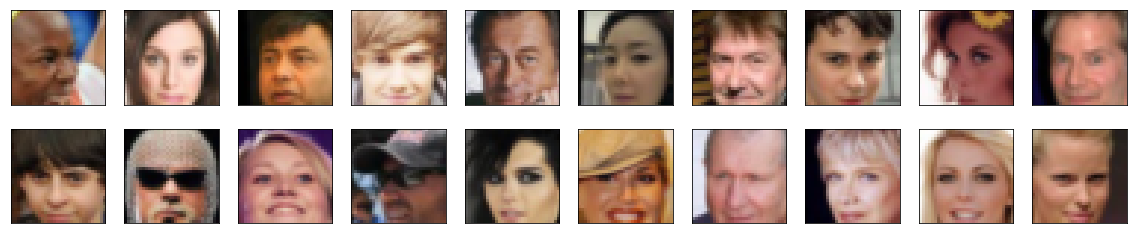

In [5]:
# Define helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

**Pre-processing: scale image data to a pixel range of -1 to 1:** The output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [6]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    x_min, x_max = feature_range
    x = x * (x_max - x_min) + x_min
    
    return x

In [7]:
# Check scaled range, should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9529)
Max:  tensor(0.9451)



## Define the Model

### Discriminator

This is like a convolutional classifier, only without any maxpooling layers. 

**Requirements:**
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake
* To deal with this complex data, it's suggested to use a deep network with _normalization_

In [8]:
# Define helper function to build conv blocks
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, 
         batch_norm=True, leaky_relu=True):
    """Creates a convolutional layer, with optional batch normalization."""
    
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2))
     
    # Return using Sequential container
    return nn.Sequential(*layers)

In [9]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """ Initialize the Discriminator Module.
        
        Arguments:
        ----------
        - conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim

        self.conv_blocks = nn.Sequential(
            conv(3, conv_dim, 4, batch_norm=False),  # out: 16 x 16 x 32
            conv(conv_dim, conv_dim * 2, 4),  # out: 8 x 8 x 64
            conv(conv_dim * 2, conv_dim * 4, 4),  # out: 4 x 4 x 128
            conv(conv_dim * 4, conv_dim * 8, 4),  # out: 2 x 2 x 256
        )
        
        self.fc = nn.Linear(conv_dim*8*2*2, 1)
        

    def forward(self, x):
        """ Forward propagation of the neural network.
        
        Arguments:
        ----------
        - x: The input to the neural network     
        
        Returns:
        --------
        - Discriminator logits; the output of the neural network
        """
        x = self.conv_blocks(x)
        x = x.view(-1, self.conv_dim*8*2*2)
        x = self.fc(x)

        return x

In [10]:
# Check
tests.test_discriminator(Discriminator)

Tests Passed


### Generator

The generator will upsample an input and generate a *new* image of the same size as our training data `32x32x3`, using mostly transpose convolutional layers with normalization applied to the outputs.

**Requirements:**
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [11]:
# Define helper function to build deconv blocks
def t_conv(in_channels, out_channels, kernel_size, stride=2, padding=1, 
         batch_norm=True, leaky_relu=True):
    """Creates a transpose convolutional layer, with optional batch norm and
    leake relu activation."""
    
    layers = []
    t_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                    kernel_size, stride, padding, bias=False)
    layers.append(t_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    if leaky_relu:
        layers.append(nn.LeakyReLU(0.2))
     
    # Return using Sequential container
    return nn.Sequential(*layers)

In [12]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """Initialize the Generator Module.
        
        Arguments:
        ----------
        - z_size: The length of the input latent vector, z
        - conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*8*2*2)  
        
        self.t_conv_blocks = nn.Sequential(
            t_conv(conv_dim * 8, conv_dim * 4, 4),
            t_conv(conv_dim * 4, conv_dim * 2, 4),
            t_conv(conv_dim * 2, conv_dim, 4),
            t_conv(conv_dim, 3, 4, batch_norm=False, leaky_relu=False),
        )
        

    def forward(self, x):
        """ Forward propagation of the neural network.
        
        Arguments:
        ----------
        - x: The input to the neural network     
        
        Returns:
        --------
        - 32x32x3 Tensor image as output
        """
        
        x = self.fc(x)
        x = x.view(-1, self.conv_dim * 8, 2, 2)  # batchsize x 256 x 2 x 2
        x = self.t_conv_blocks(x)
        x = F.tanh(x)
        
        return x

In [13]:
# Check model
tests.test_generator(Generator)

Tests Passed


### Initialize networks weights 

To help the models converge, we initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say: All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

(A more advanced model code can be found in [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py)).

**Requirements:**

* Initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [14]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model. The weights are taken 
    from a normal distribution with mean = 0, std dev = 0.02.
    
    Arguments:
    ----------
    - m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)
    elif classname.find('Conv') != -1:
        m.weight.data.normal_(0, 0.02)
#         m.bias.data.fill_(0)  # bias was set to false

## Build complete network


In [15]:
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G

In [16]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv_blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
  )
  (fc): Linear(in_features=1024, out_features=1

**Training on GPU**

In [17]:
# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')

Training on GPU!


## Define Losses

**Discriminator Losses**

* For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* We want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


**Generator Loss**

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.


**We may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [18]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       
    Arguments:
    ----------
    - D_out: discriminator logits

    Returns:
    --------
    - real loss
    '''
    
    batch_size = D_out.size(0)
    if smooth:
        labels = torch.rand(batch_size) * 0.1 + 0.9 # real labels 0.9 to 1.0
    else:
        labels = torch.ones(batch_size) # real labels = 1   
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       
    Arguments:
    ----------
    - D_out: discriminator logits

    Returns:
    --------
    - fake loss
    '''
    
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out.squeeze(), labels)
    
    return loss

In [19]:
# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.5
beta2 = 0.999 

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2]) 


## Train model

Training will involve alternating between training the discriminator and the generator and alternating between real and fake images. 

**Saving Samples:** Code is included to print out some loss statistics and save some generated "fake" samples.

In [22]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # Move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # Keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # Epoch training loop
    for epoch in range(n_epochs):

        # Batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
 
            if train_on_gpu:
                real_images = real_images.cuda()
            d_real = D(real_images)
            d_real_loss = real_loss(d_real)

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            d_fake = D(fake_images)
            d_fake_loss = fake_loss(d_fake)

            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)

            d_fake_images = D(fake_images)
            g_loss = real_loss(d_fake_images) # use real loss to flip labels
            g_loss.backward()
            g_optimizer.step()            

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))
 
        # After each epoch, generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

In [24]:
n_epochs = 60
print_every = 100

# Call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   60] | d_loss: 0.8934 | g_loss: 1.4018
Epoch [    1/   60] | d_loss: 1.0101 | g_loss: 1.2537
Epoch [    1/   60] | d_loss: 1.0371 | g_loss: 1.2713
Epoch [    1/   60] | d_loss: 1.1651 | g_loss: 0.7335
Epoch [    1/   60] | d_loss: 0.9119 | g_loss: 1.7728
Epoch [    1/   60] | d_loss: 0.9135 | g_loss: 2.3754
Epoch [    1/   60] | d_loss: 1.0467 | g_loss: 1.0325
Epoch [    1/   60] | d_loss: 0.9661 | g_loss: 1.6126
Epoch [    1/   60] | d_loss: 0.8791 | g_loss: 1.6138
Epoch [    1/   60] | d_loss: 1.0566 | g_loss: 1.4012
Epoch [    1/   60] | d_loss: 1.0409 | g_loss: 0.9823
Epoch [    1/   60] | d_loss: 0.9857 | g_loss: 1.1757
Epoch [    1/   60] | d_loss: 1.0881 | g_loss: 1.8239
Epoch [    1/   60] | d_loss: 0.8927 | g_loss: 1.2759
Epoch [    1/   60] | d_loss: 0.8194 | g_loss: 1.2884
Epoch [    1/   60] | d_loss: 1.1513 | g_loss: 0.7830
Epoch [    1/   60] | d_loss: 1.0051 | g_loss: 1.3842
Epoch [    1/   60] | d_loss: 1.1556 | g_loss: 1.3446
Epoch [    1/   60] | d_loss

## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

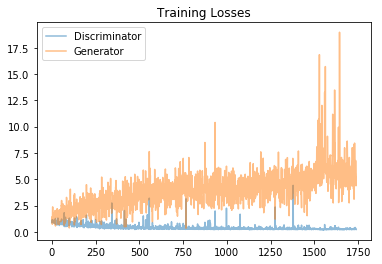

In [25]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [26]:
# Define helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [27]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

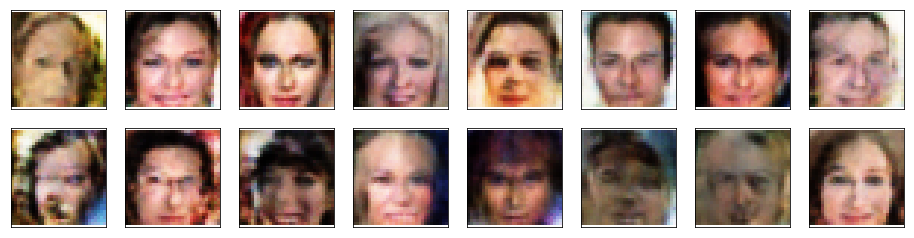

In [28]:
# After 1 Epoch
_ = view_samples(1, samples)

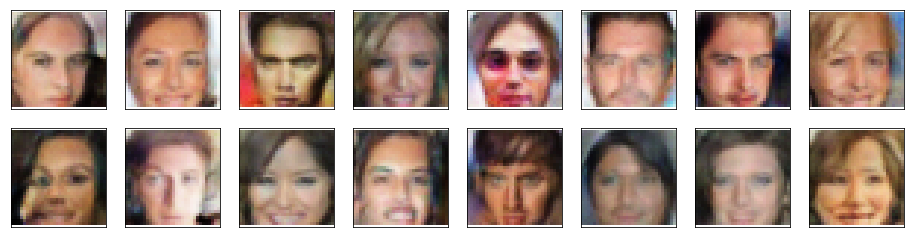

In [29]:
# After 20 Epochs
_ = view_samples(20, samples)

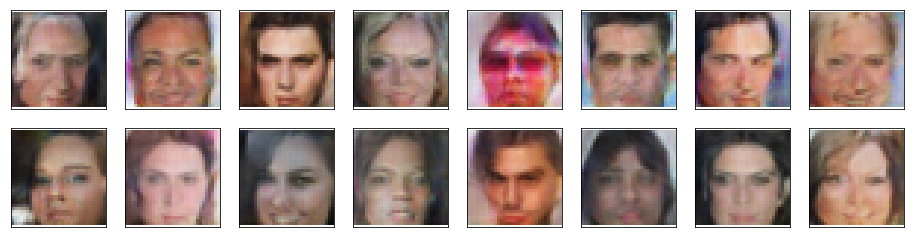

In [30]:
# After 40 Epochs
_ = view_samples(40, samples)

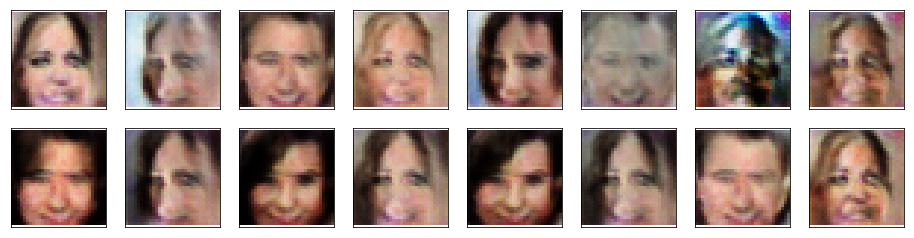

In [31]:
# After 60 Epochs
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result

**Answer:**

* Bias: Because of the input data the model is not capable to generate faces of non-white people - see results. (Ok, there is the occasional red  face and in the end even a blue face in the generated samples, but that is not really intended ;-)) If one would wish to generate faces of different colors, the input data set would have to be more balanced.
* Model size: A larger model would certainly have helped as can be seen be seen from the results. The faces are far from perfect. In comparison with the model architecture I have added one additional conv / t-conv layer to each the discriminator and the generator. Most probably a larger model would also have permitted to work effectively with input data that has a higher resolution, leading to better results.
* Optimization: It is interesting to see how the generator loss is constantly increasing over training and has wild swings towards the end of the 60 epochs that I trained the model. And when we look at the generated samples I think those after 40 epochs are better than the final batch. So I cannot say with certainty that longer training might have improved the performance. Rather I would suggest to experiment with the params for the learning rate (maybe a dynamic one) and the beta values, the batch size or - most of all - the conv_dims that were set to a (too) low 32. 64 or 128 might allow the model to learn better and generate less 'low-res' results.

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.